In [1]:
import hopsworks
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import numpy as np
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import os

2023-11-15 23:01:54,433 WARNING: From C:\Users\carl\PycharmProjects\ID2223_lab1\venv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.



In [4]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/191638
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
weather_fg = fs.get_feature_group(name="weather", version=1)
query = weather_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="weather",
                                  version=1,
                                  description="",
                                  labels=["temperature_2m", "apparent_temperature", "rain", 'snowfall', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'wind_direction_10m'],
                                  query=query)
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start="2023-01-01",
    train_end="2023-09-13",    
    test_start="2023-09-14", 
    test_end="2023-12-31", 
    description='Weather dataset for 2023'
)

Finished: Reading data from Hopsworks, using ArrowFlight (1.05s) 


In [6]:
n_input = 8 # Number of features
n_hidden = 256  # Number of hidden nodes
n_out = 8 # Number of classes

class WeatherModel(nn.Module):
    def __init__(self):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.bn1 = nn.BatchNorm1d(n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        self.bn2 = nn.BatchNorm1d(n_hidden)
        self.fc3 = nn.Linear(n_hidden, n_hidden)
        self.bn3 = nn.BatchNorm1d(n_hidden)
        self.fc4 = nn.Linear(n_hidden, n_hidden)
        self.bn4 = nn.BatchNorm1d(n_hidden)
        self.fc5 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.out(self.fc5(x))
        return torch.softmax(x, dim=1)

model = WeatherModel()

# Define loss function, optimizer, and convert data to tensors
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00025)
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

# Training loop
epochs = 150
batch_size = 256
for epoch in range(epochs):
    for i in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        batch_x, batch_y = X_train[i:i+batch_size], y_train[i:i+batch_size]
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / len(y_test)
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}, Accuracy: {accuracy}')

In [19]:
y_train

,type,volatile_acidity,citric_acid,chlorides,total_sulfur_dioxide,density,alcohol
0,0,0.28,0.14,0.032,142.0,0.99542,9.500000
1,0,0.25,0.41,0.042,173.0,0.99650,9.100000
2,0,0.33,0.27,0.036,134.0,0.99270,10.400000
4,0,0.28,0.31,0.046,208.0,0.99434,9.800000
5,0,0.51,0.25,0.048,177.0,0.99212,10.566667
...,...,...,...,...,...,...,...
5264,0,0.20,0.26,0.046,143.0,0.99526,10.800000
5265,0,0.28,0.36,0.038,101.0,0.99120,11.600000
5266,0,0.18,0.31,0.058,167.0,0.99310,10.000000
5267,0,0.35,0.25,0.051,182.0,0.99946,9.300000


In [20]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

,quality
0,1
1,0
2,2
4,0
5,0
...,...
5264,1
5265,1
5266,2
5267,1


In [21]:
print(metrics)

17/17 [==============================] - 0s 906us/step


In [22]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
#df_cm = pd.DataFrame(results, ['True Low Quality', 'True Good Quality', 'True High Quality'],
#                     ['Pred Low Quality', 'Pred Good Quality', 'Pred High Quality'])
#cm = sns.heatmap(df_cm, annot=True, fmt='g')
#sns.set(rc={'figure.figsize':(11.7,8.27)})
#fig = cm.get_figure()

{'0': {'precision': 0.6273584905660378, 'recall': 0.689119170984456, 'f1-score': 0.6567901234567901, 'support': 193.0}, '1': {'precision': 0.5404040404040404, 'recall': 0.46120689655172414, 'f1-score': 0.4976744186046511, 'support': 232.0}, '2': {'precision': 0.5042735042735043, 'recall': 0.5784313725490197, 'f1-score': 0.5388127853881278, 'support': 102.0}, 'accuracy': 0.5673624288425048, 'macro avg': {'precision': 0.5573453450811942, 'recall': 0.5762524800283999, 'f1-score': 0.564425775816523, 'support': 527.0}, 'weighted avg': {'precision': 0.5652558320472109, 'recall': 0.5673624288425048, 'f1-score': 0.5639086585446462, 'support': 527.0}}


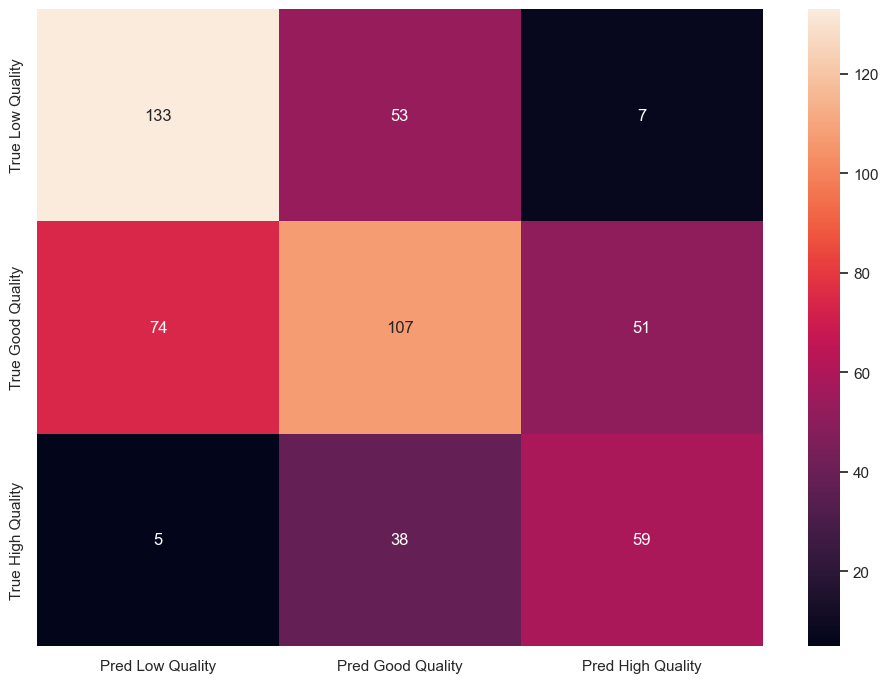

In [23]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="weather_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
model.save_weights(model_dir + '/weather_model.h5')
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
weather_model = mr.python.create_model(
    name="weather_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Weather predictor for Stockholm"
)

# Upload the model to the model registry, including all files in 'model_dir'
weather_model.save(model_dir)